# README

Il y a 3 notebooks : 
- PSanté_01_notebooknettoyage : ce qui touche au preprocessing 
- PSanté_02_notebooknettoyage : ce qui touche à la modélisation 
- Analyse_anomalie : qui est un copié-collé de PSanté_02_notebooknettoyage, avec à la fin toutes les tests que j'ai réalisé pour essayer de comprendre le pb. J'ai éclaté certaines de mes fonctions pour qu'on puisse plus facilement accéder aux variables. 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from numpy import percentile
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
import pickle 
from sklearn.neighbors import KDTree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import f_oneway
import sklearn.metrics as metrics
import math
import time
start_time = time.time()

In [2]:
outliers=pd.read_csv("Data/export_outliers.csv",low_memory=False)
train=pd.read_csv("Data/train_export.csv")
test=(
    pd.read_csv("Data/test_export.csv")
    .drop(columns=['Numb_nan_line'],axis=1))

In [3]:
test.shape

(101579, 15)

# Verification imputer 

In [4]:
#We want to check the efficiency of our imputer, so we are going to transform some none Nan values by some Nan
#And then compare 
test.loc[test['code']=='7616700102017','proteins_100g']=test.loc[test['code']=='7616700102017',
                                                                 'proteins_100g']=np.nan
test.loc[test['code']=='3267110007023','fiber_100g']=test.loc[test['code']=='3267110007023','fiber_100g']=np.nan
test.loc[test['code']=='3266920007515','energy_100g']=test.loc[test['code']=='3266920007515','energy_100g']=np.nan
test.loc[test['code']=='0400101046431','sugars_100g']=test.loc[test['code']=='0400101046431',
                                                                 'sugars_100g']=np.nan

In [5]:
test.head(n=20)

,code,product_name,generic_name,quantity,fiber_100g,proteins_100g,fruits-vegetables-nuts_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,nutrition-score-fr_100g,carbohydrates_100g,fat_100g,nutriscore_grade
0,4250665323358,Magnesium-Citrat,NaN,℮ 250 g,0.0,0.00,NaN,1139.0,0.00,1.50,0.03000,3.0,4.20,0.00,c
1,3268350120688,Biscottes à la farine complète et graines de lin,Biscottes à la farine complète et graines de lin,270 g,12.4,13.40,NaN,1622.0,1.20,0.30,1.40000,6.0,72.00,7.90,c
2,4335896750255,Bio Tofu Hack,NaN,200 g,0.5,21.00,NaN,1120.0,2.90,0.80,0.93000,4.0,5.20,18.00,c
3,8801005123495,Crispy seaweed snack,NaN,NaN,NaN,50.00,NaN,1799.0,0.00,3.00,2.00000,13.0,50.00,0.00,d
4,0213400023290,Filet de poulet,NaN,NaN,NaN,23.00,NaN,435.0,0.40,0.00,0.11000,-4.0,0.00,1.30,a
5,0725439980890,Hummus,NaN,NaN,3.6,7.14,NaN,598.0,0.00,3.57,0.90678,-2.0,17.86,5.36,a
6,8437000639404,Claras de huevo,NaN,NaN,NaN,11.30,NaN,209.0,0.00,0.70,0.30000,-4.0,0.70,0.00,a
7,5708190025050,Rooibos Tea Elderberry Ginger Ginseng Agave,NaN,330 ml e,0.0,0.00,NaN,71.0,0.00,3.80,0.00300,6.0,3.90,0.00,d
8,3564707121231,Compotes multi variétés allégées en sucres bio,NaN,12 x 90 g,1.6,0.50,96.0,273.0,0.10,13.80,0.01000,-3.0,15.50,0.50,a
9,3760074411306,Galettes bretonnes,NaN,NaN,NaN,8.20,NaN,2167.0,19.00,18.00,0.74000,22.0,51.00,31.00,e


In [6]:
#This dataset was cleaned by a preprocessing done in the other notebook
train.shape

(189557, 14)

In [7]:
train.head()

,fiber_100g,proteins_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,carbohydrates_100g,fat_100g,mean_tree,code,product_name,nutrition-score-fr_100g,nutriscore_grade,verif
0,4.00,7.0,2293.0,19.5,15.5,0.16000,53.0,34.00,0.209743,5413415206304,Chocolat Lait Cannelle de Ceylan,22.0,e,94.00
1,2.90,3.9,674.0,0.7,0.9,1.50000,22.8,5.60,0.128701,3760054096042,Taboule Oriental,6.0,c,32.30
2,1.25,1.4,1197.0,0.3,18.5,0.00000,66.3,1.40,0.024792,3701269300432,Pâte à tartiner châtaigne cacao,12.0,d,69.10
3,0.00,20.0,1159.0,15.5,0.0,1.50000,0.0,21.90,0.054727,3177870001042,Camembert de Normandie,14.0,d,41.90
4,0.00,3.4,359.0,0.8,14.2,0.12319,15.4,1.42,0.052760,0056920052421,Yoplait Crémeux vanille,2.0,b,20.22


In [8]:
test.head()

,code,product_name,generic_name,quantity,fiber_100g,proteins_100g,fruits-vegetables-nuts_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,nutrition-score-fr_100g,carbohydrates_100g,fat_100g,nutriscore_grade
0,4250665323358,Magnesium-Citrat,NaN,℮ 250 g,0.0,0.0,NaN,1139.0,0.0,1.5,0.03,3.0,4.2,0.0,c
1,3268350120688,Biscottes à la farine complète et graines de lin,Biscottes à la farine complète et graines de lin,270 g,12.4,13.4,NaN,1622.0,1.2,0.3,1.40,6.0,72.0,7.9,c
2,4335896750255,Bio Tofu Hack,NaN,200 g,0.5,21.0,NaN,1120.0,2.9,0.8,0.93,4.0,5.2,18.0,c
3,8801005123495,Crispy seaweed snack,NaN,NaN,NaN,50.0,NaN,1799.0,0.0,3.0,2.00,13.0,50.0,0.0,d
4,0213400023290,Filet de poulet,NaN,NaN,NaN,23.0,NaN,435.0,0.4,0.0,0.11,-4.0,0.0,1.3,a


## I- Tests statistiques 

### 1) test de correlation 

Tests de normalité

Nous allons tester la normalité de la distribution statistique. Voici le test statistique :

H0 : les valeurs de la variable 'nutrition-score-fr_100g' pour l'échantillon sont issus d'une population normalement distribuée.

H1 : les valeurs de la variable 'nutrition-score-fr_100g' pour l'échantillon NE sont PAS issus d'une population normalement distribuée

In [9]:
# Shapiro-Wilk Test

# normality test
stat, p = shapiro(train['nutrition-score-fr_100g'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.974, p=0.000
Sample does not look Gaussian (reject H0)


/data/arnaud/.local/lib/python3.5/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [10]:
# normality test
liste=['fiber_100g', 'proteins_100g', 'energy_100g', 'saturated-fat_100g',
       'sugars_100g', 'salt_100g', 'carbohydrates_100g', 'fat_100g',
       'mean_tree', 'nutrition-score-fr_100g','verif']
for i in liste : 
    stat, p = shapiro(train[i])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
    alpha = 0.05
    if p > alpha:
        print('For',i,'Sample looks Gaussian (fail to reject H0)')
    else:
        print('For',i,'Sample does not look Gaussian (reject H0)')

Statistics=0.833, p=0.000
For fiber_100g Sample does not look Gaussian (reject H0)
Statistics=0.884, p=0.000
For proteins_100g Sample does not look Gaussian (reject H0)
Statistics=0.956, p=0.000
For energy_100g Sample does not look Gaussian (reject H0)
Statistics=0.793, p=0.000
For saturated-fat_100g Sample does not look Gaussian (reject H0)
Statistics=0.788, p=0.000
For sugars_100g Sample does not look Gaussian (reject H0)
Statistics=0.868, p=0.000
For salt_100g Sample does not look Gaussian (reject H0)
Statistics=0.865, p=0.000
For carbohydrates_100g Sample does not look Gaussian (reject H0)
Statistics=0.857, p=0.000
For fat_100g Sample does not look Gaussian (reject H0)
Statistics=0.874, p=0.000
For mean_tree Sample does not look Gaussian (reject H0)
Statistics=0.974, p=0.000
For nutrition-score-fr_100g Sample does not look Gaussian (reject H0)
Statistics=0.917, p=0.000
For verif Sample does not look Gaussian (reject H0)


In [11]:
train.isna().sum()

fiber_100g                    0
proteins_100g                 0
energy_100g                   0
saturated-fat_100g            0
sugars_100g                   0
salt_100g                     0
carbohydrates_100g            0
fat_100g                      0
mean_tree                     0
code                          0
product_name               1159
nutrition-score-fr_100g       0
nutriscore_grade              1
verif                         0
dtype: int64

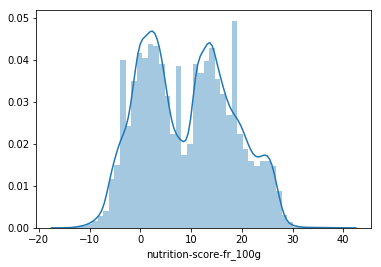

In [12]:
sns.distplot(train['nutrition-score-fr_100g']);

In [13]:
# Kolmogorov-Smirnov test
for i in liste : 
    stat, p = stats.kstest((train[i]),'norm')
    print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
    alpha = 0.05
    if p > alpha:
        print('For',i,'Sample looks Gaussian (fail to reject H0)')
    else:
        print('For',i,'Sample does not look Gaussian (reject H0)')


Statistics=0.500, p=0.000
For fiber_100g Sample does not look Gaussian (reject H0)
Statistics=0.727, p=0.000
For proteins_100g Sample does not look Gaussian (reject H0)
Statistics=0.999, p=0.000
For energy_100g Sample does not look Gaussian (reject H0)
Statistics=0.500, p=0.000
For saturated-fat_100g Sample does not look Gaussian (reject H0)
Statistics=0.605, p=0.000
For sugars_100g Sample does not look Gaussian (reject H0)
Statistics=0.500, p=0.000
For salt_100g Sample does not look Gaussian (reject H0)
Statistics=0.816, p=0.000
For carbohydrates_100g Sample does not look Gaussian (reject H0)
Statistics=0.686, p=0.000
For fat_100g Sample does not look Gaussian (reject H0)
Statistics=0.500, p=0.000
For mean_tree Sample does not look Gaussian (reject H0)
Statistics=0.737, p=0.000
For nutrition-score-fr_100g Sample does not look Gaussian (reject H0)
Statistics=0.986, p=0.000
For verif Sample does not look Gaussian (reject H0)


Une distribution bimodale est une distribution statistique présentant plusieurs modes et par définition ne suit pas une loi normale. 

In [14]:
heat1=train.copy()

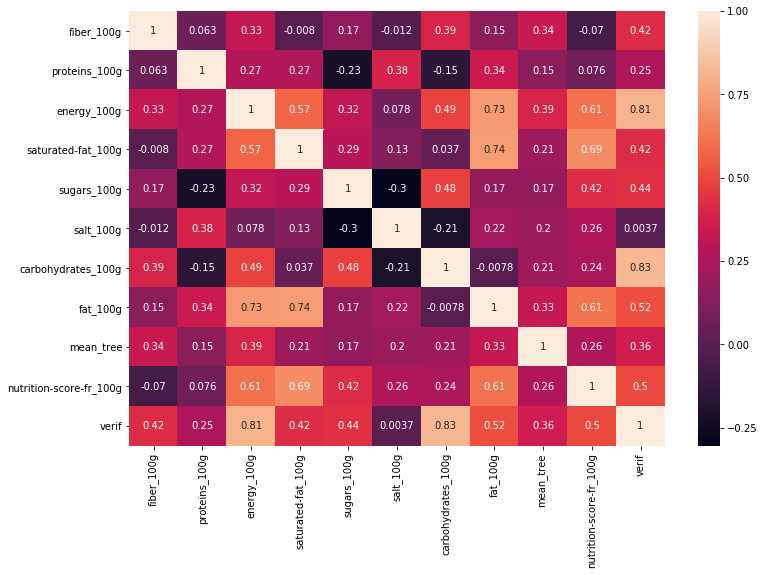

In [15]:
plt.figure(figsize=(12, 8))

vg_corr = heat1.corr()
sns.heatmap(vg_corr, 
            xticklabels = vg_corr.columns.values,
            yticklabels = vg_corr.columns.values,
            annot = True);

In [16]:
#Pearson correlation test 
from scipy.stats import pearsonr

stat, p = pearsonr(train['fat_100g'], train['saturated-fat_100g'])
print('stat=%.3f, p=%.3f' % (stat, p))

alpha=0.05

if p > alpha:
	print('fat_100g and saturated-fat_100g are probably independent')
else:
	print('fat_100g and saturated-fat_100g are probably dependent')


stat=0.736, p=0.000
fat_100g and saturated-fat_100g are probably dependent


## Anova 

In [17]:
train.columns

Index(['fiber_100g', 'proteins_100g', 'energy_100g', 'saturated-fat_100g',
       'sugars_100g', 'salt_100g', 'carbohydrates_100g', 'fat_100g',
       'mean_tree', 'code', 'product_name', 'nutrition-score-fr_100g',
       'nutriscore_grade', 'verif'],
      dtype='object')

In [18]:
X = "nutriscore_grade" # qualitative
Y = "fiber_100g" # quantitative

sous_echantillon = train.copy()
sous_echantillon.dropna(subset = ["product_name","nutriscore_grade"], inplace=True)


# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

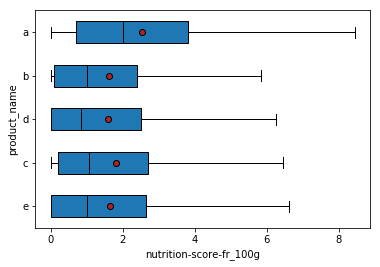

In [19]:
modalites = sous_echantillon[X].unique()
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel("nutrition-score-fr_100g")
plt.ylabel("product_name")
plt.show()

In [20]:
# Example of the Analysis of Variance Test
stat, p = f_oneway(sous_echantillon['fiber_100g'][sous_echantillon['nutriscore_grade']=='a'],
                   sous_echantillon['fiber_100g'][sous_echantillon['nutriscore_grade']=='b'],
                   sous_echantillon['fiber_100g'][sous_echantillon['nutriscore_grade']=='c'],
                   sous_echantillon['fiber_100g'][sous_echantillon['nutriscore_grade']=='d'],
                   sous_echantillon['fiber_100g'][sous_echantillon['nutriscore_grade']=='e'])

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=1191.976, p=0.000
Probably different distributions


# ACP 

In [21]:
train.columns

Index(['fiber_100g', 'proteins_100g', 'energy_100g', 'saturated-fat_100g',
       'sugars_100g', 'salt_100g', 'carbohydrates_100g', 'fat_100g',
       'mean_tree', 'code', 'product_name', 'nutrition-score-fr_100g',
       'nutriscore_grade', 'verif'],
      dtype='object')

In [22]:
acp_col=['fiber_100g', 'proteins_100g', 'energy_100g', 'saturated-fat_100g',
       'sugars_100g', 'salt_100g', 'carbohydrates_100g', 'fat_100g']

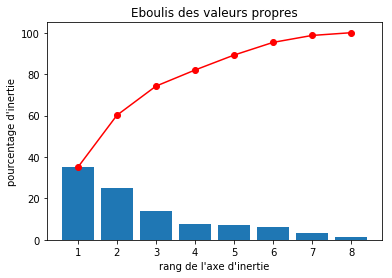

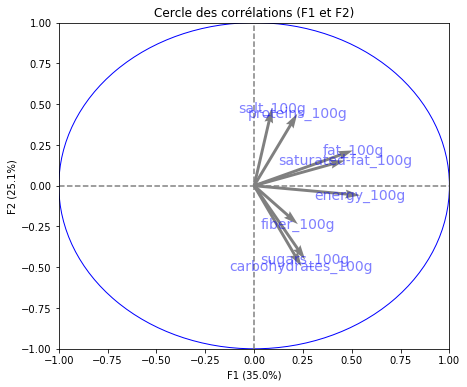

In [23]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

# choix du nombre de composantes à calculer
n_comp = 8

# import de l'échantillon
data = train[acp_col]

# selection des colonnes à prendre en compte dans l'ACP
data_pca = train[acp_col]

# préparation des données pour l'ACP
#data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = data.index # ou data.index pour avoir les intitulés
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)#ici

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Projection des individus
#X_projected = pca.transform(X_scaled)#ici
#display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=np.array(names))
#display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=pure['is_genuine'])

plt.show()

# KNN

In [24]:
acp_col

['fiber_100g',
 'proteins_100g',
 'energy_100g',
 'saturated-fat_100g',
 'sugars_100g',
 'salt_100g',
 'carbohydrates_100g',
 'fat_100g']

In [25]:
scaler = StandardScaler()
train_sca=(scaler.fit_transform(train[acp_col]))

In [26]:
X_train = train_sca
y_train= train['nutrition-score-fr_100g']

# we could choose differenct neighbors to see which K is the best K.


In [27]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors': list(range(1,31))}

knn = KNeighborsRegressor()
model = GridSearchCV(knn, parameters, cv=5,scoring='neg_mean_absolute_error')
model.fit(X_train,y_train)
print('Le nb de K optimal pour le MAE :', model.best_params_)
mae=np.abs(model.best_score_)

Le nb de K optimal pour le MAE : {'n_neighbors': 9}


In [28]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors': list(range(1,31))}

knn = KNeighborsRegressor()
#RMSE
model = GridSearchCV(knn, parameters, cv=5,scoring='neg_root_mean_squared_error')
model.fit(X_train,y_train)
print('Le nb de K optimal pour le RMSE :', model.best_params_)
rmse=(np.abs(model.best_score_))

Le nb de K optimal pour le RMSE : {'n_neighbors': 16}


In [29]:
print ("TRAINING SET( without % nutrition-score-fr_100g)")
print ("=========================================")
print ("MAE:                ", mae)
print ("RMSE:               ", rmse)

TRAINING SET( without % nutrition-score-fr_100g)
MAE:                 2.176053383322187
RMSE:                3.4440734635654096


In [30]:
model.cv_results_

{'mean_fit_time': array([0.26234365, 0.26188855, 0.26183853, 0.26143928, 0.261901  ,
        0.26519985, 0.26169062, 0.26181054, 0.26148195, 0.26222148,
        0.26165714, 0.26125708, 0.26289229, 0.26156316, 0.26157227,
        0.264782  , 0.26431141, 0.26511755, 0.26502161, 0.26555161,
        0.26434288, 0.26510634, 0.26630144, 0.26117153, 0.26126289,
        0.26085429, 0.26073952, 0.26040597, 0.26420231, 0.26043916]),
 'mean_score_time': array([1.04338026, 1.39396133, 1.65194535, 1.85107403, 2.00163364,
        2.15109706, 2.2791121 , 2.39751668, 2.51730695, 2.61599073,
        2.7181797 , 2.81040916, 2.89982276, 2.99875112, 3.08001823,
        3.18847332, 3.27542272, 3.359273  , 3.46836815, 3.50638528,
        3.55487018, 3.63784328, 3.70267291, 3.80435691, 3.84177079,
        3.88479199, 3.95288472, 4.01125207, 4.07598763, 4.13446975]),
 'mean_test_score': array([-4.29449599, -3.81526111, -3.64733513, -3.56951246, -3.52675586,
        -3.49823256, -3.47874022, -3.46946816, -3.45

Text(0, 0.5, 'RMSE')

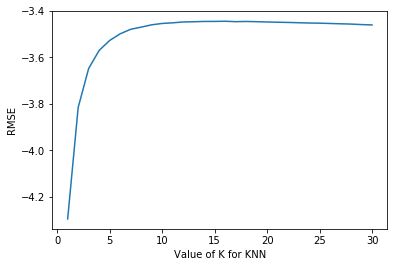

In [31]:
k_range = range(1, 31)
plt.plot(k_range, model.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('RMSE')

# Fonctions préprocessing 

In [32]:
train.columns

Index(['fiber_100g', 'proteins_100g', 'energy_100g', 'saturated-fat_100g',
       'sugars_100g', 'salt_100g', 'carbohydrates_100g', 'fat_100g',
       'mean_tree', 'code', 'product_name', 'nutrition-score-fr_100g',
       'nutriscore_grade', 'verif'],
      dtype='object')

In [33]:
outliers.head()

,Name,Q1,Q3
0,fiber_100g,-5.550,9.250
1,proteins_100g,-13.500,27.300
2,fruits-vegetables-nuts_100g,-81.775,161.625
3,saturated-fat_100g,-11.800,20.200
4,sugars_100g,-21.950,38.450


In [34]:
outliers['Name'].unique()

array(['fiber_100g', 'proteins_100g', 'fruits-vegetables-nuts_100g',
       'saturated-fat_100g', 'sugars_100g', 'salt_100g',
       'carbohydrates_100g', 'fat_100g', 'energy_100g', 'mean_tree'],
      dtype=object)

- La fonction boxplot_methode va dans un premier gérer les valeurs aberrantes en mettant à Nan les valeurs supérieur à 100 et inférieur à 0
- Puis nous récupérons la valeur de l'IRQ dans nos jeux de données outlier pour l'appliquer à notre jeu de données 'test' pour chaque colonne

In [35]:
def boxplot_methode(main_df,df_outliers):
    '''boxplot_methode has to goal to put all the outliers to Nan through the boxplot method, we are going to use the Q1 and Q3 from train dataset'''
    global test,outliers
    boxo=['fiber_100g','proteins_100g','fruits-vegetables-nuts_100g','saturated-fat_100g','sugars_100g','salt_100g','carbohydrates_100g','fat_100g']
    for i in boxo: 
        test.loc[(test[i]<0)|(test[i]>100),
                  i]=test.loc[(test[i]<0)|(test[i]>100),i]=np.nan
        Q1 = int(outliers.loc[outliers['Name']==i,'Q1'])
        Q3 = int(outliers.loc[outliers['Name']==i,'Q3'])
        test.loc[(test[i] < (Q1)) | (test[i] > (Q3)),
                  i]=test.loc[(test[i] < (Q1)) | (test[i] > (Q3)),
                                 i]=np.nan

In [36]:
boxplot_methode(test,outliers)

In [37]:
#Ici nous pouvons constater que le nombre de Nan a augmenté puisque toutes les valeurs aberrantes et outliers st mis à Nan
test.isna().sum()

code                                0
product_name                      584
generic_name                    78544
quantity                        42473
fiber_100g                      61760
proteins_100g                    2996
fruits-vegetables-nuts_100g    100077
energy_100g                       141
saturated-fat_100g               6063
sugars_100g                     11456
salt_100g                        5467
nutrition-score-fr_100g             0
carbohydrates_100g                255
fat_100g                         3822
nutriscore_grade                    0
dtype: int64

In [38]:
def percent_methode(test_df,df_outliers): 
        '''percent_methdode has to goal to put all the outliers to Nan through the boxplot method, we are going to use the Q1 and Q3 from train dataset
        , wich represent the 1st percentile and the 99th percentile'''
        global test,outliers
        colo=['energy_100g']
        for i in colo: 
            Q1 = int(outliers.loc[outliers['Name']==i,'Q1'])
            Q3 = int(outliers.loc[outliers['Name']==i,'Q3'])
            test.loc[(test[i] <= (Q1)) | (test[i] >= (Q3)),
                  i]=test.loc[(test[i] <= (Q1)) | (test[i] >= (Q3)),
                                 i]=np.nan

In [39]:
percent_methode(test,outliers)

In [40]:
test.isna().sum()

code                                0
product_name                      584
generic_name                    78544
quantity                        42473
fiber_100g                      61760
proteins_100g                    2996
fruits-vegetables-nuts_100g    100077
energy_100g                      2220
saturated-fat_100g               6063
sugars_100g                     11456
salt_100g                        5467
nutrition-score-fr_100g             0
carbohydrates_100g                255
fat_100g                         3822
nutriscore_grade                    0
dtype: int64

In [41]:
%%time
def knn_imputation(dataframe):
    '''knn_imputation is going to impute the missing values through KnnImputer that will be stocked into df_filled'''
    global df_filled
    knn=['fiber_100g','proteins_100g',
                'energy_100g','saturated-fat_100g','sugars_100g','salt_100g','carbohydrates_100g','fat_100g']
    with open('StandardScaler_pickle', 'rb') as file: 
        scaler=pickle.load(file)
    data=(scaler.transform(dataframe[knn]))
    with open('imputer_pickle', 'rb') as file: 
        imputer=pickle.load(file)
    df_filled = imputer.transform(data)
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs


In [42]:
%%time
knn_imputation(test)

CPU times: user 27min 47s, sys: 13min 58s, total: 41min 45s
Wall time: 19min 58s


In [43]:
X=df_filled.copy()
tree = KDTree(X, leaf_size=2)              
dist, ind = tree.query(X, k=5)
dist_mean=[]
for i in dist:
     dist_mean.append(i.mean())
data=(scaler.inverse_transform(df_filled))


In [44]:
#Creation of the new dataframe : "dataframe"
dataframe=pd.DataFrame(data, columns=['fiber_100g','proteins_100g',
                'energy_100g','saturated-fat_100g','sugars_100g','salt_100g','carbohydrates_100g','fat_100g'])
dataframe['mean_tree']=dist_mean



In [45]:
print("dataframe",dataframe.shape)
print("test",test.shape)

dataframe (101579, 9)
test (101579, 15)


In [46]:
#Since we have kept the same order of information, we can simply put the test values into dataframe.
#To retrieve the code, product_name and nutrition score 
dataframe['code']=test['code'].values
dataframe['product_name']=test['product_name'].values
dataframe['nutrition-score-fr_100g']=test['nutrition-score-fr_100g'].values

In [47]:
#The result True is perfectly normal
dataframe['code'].equals(test['code'])

True

In [48]:
#Now it seems that we took care of some redundants articles with their code but there are others with different names
#Since we are using knn and its an algorithm using the distance we need to drop those products
#For this, since I don't know who is who ? We are going to use those columns as a reference and keep only one of them each time
dataframe.drop_duplicates(subset =['fiber_100g','proteins_100g',
                'energy_100g','saturated-fat_100g','sugars_100g','salt_100g','carbohydrates_100g','fat_100g'], 
                     keep = "first", inplace = True) 

In [49]:
#The result False is perfectly normal, we wanted to check if the drop did his job
dataframe['code'].equals(test['code'])

False

In [50]:
print("dataframe",dataframe.shape)

dataframe (88168, 12)


In [51]:
test_clean=dataframe.copy()

In [52]:
test_clean['verif']=test_clean['proteins_100g']+test_clean['carbohydrates_100g']+test_clean['fat_100g']

In [53]:
test_clean.isna().sum()

fiber_100g                   0
proteins_100g                0
energy_100g                  0
saturated-fat_100g           0
sugars_100g                  0
salt_100g                    0
carbohydrates_100g           0
fat_100g                     0
mean_tree                    0
code                         0
product_name               548
nutrition-score-fr_100g      0
verif                        0
dtype: int64

In [54]:
def verification(main_test): 
    global test_clean
    test_clean=test_clean.loc[(test_clean['verif']>=0)&(test_clean['verif']<=100),:]
    outlier_kd=['mean_tree']
    for i in outlier_kd: 
        test_clean=test_clean.loc[(test_clean[i]>=0)|(test_clean[i]<=100),:]
        Q1 = int(outliers.loc[outliers['Name']==i,'Q1'])
        Q3 = int(outliers.loc[outliers['Name']==i,'Q3'])
        test_clean=test_clean.loc[(test_clean[i] < (Q1)) | (test_clean[i] > (Q3 )),
                                 :]

In [55]:
verification(test_clean)

In [56]:
liste_knn=['fiber_100g','proteins_100g',
                'energy_100g','saturated-fat_100g','sugars_100g','salt_100g','carbohydrates_100g','fat_100g']

In [57]:
y_pred1=model.best_estimator_.predict(test_clean[liste_knn])

In [58]:
y_test1=test_clean['nutrition-score-fr_100g']

In [59]:
mae1 = metrics.mean_absolute_error(y_test1, y_pred1)
mse1 = metrics.mean_squared_error(y_test1,y_pred1)
print ("Test SET( without % nutrition-score-fr_100g)")
print ("=========================================")
print ("MAE:                ", mae1)
print ("RMSE:               ", math.sqrt(mse1))

Test SET( without % nutrition-score-fr_100g)
MAE:                 11.136399632732699
RMSE:                13.349612899396245


In [60]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2197.51411652565 seconds ---


In [61]:
test_clean

,fiber_100g,proteins_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,carbohydrates_100g,fat_100g,mean_tree,code,product_name,nutrition-score-fr_100g,verif
0,-0.094588,0.209908,1124.952412,0.198196,2.541504,0.047373,5.986183,0.271275,0.177711,4250665323358,Magnesium-Citrat,3.0,6.467366
1,5.920622,12.947544,1593.237537,1.415041,1.187020,1.428436,72.684866,8.096399,0.355403,3268350120688,Biscottes à la farine complète et graines de lin,6.0,93.728808
2,0.354309,20.171875,1106.531258,3.138904,1.751388,0.954640,6.969939,18.100671,0.260782,4335896750255,Bio Tofu Hack,4.0,45.242485
3,0.803205,5.913327,1764.845129,0.198196,4.234609,2.033281,51.042225,0.271275,0.765450,8801005123495,Crispy seaweed snack,13.0,57.226827
5,3.137465,6.996977,600.434291,0.198196,4.877988,0.931233,19.424295,5.580473,0.231432,0725439980890,Hummus,-2.0,32.001745
6,-0.049698,10.951347,223.285402,0.198196,1.638515,0.319553,2.543036,0.271275,0.111650,8437000639404,Claras de huevo,-4.0,13.765658
7,-0.094588,0.209908,89.489652,0.198196,5.137598,0.020155,5.691056,0.271275,0.009009,5708190025050,Rooibos Tea Elderberry Ginger Ginseng Agave,6.0,6.172239
8,1.341880,0.685193,285.335605,0.299599,16.424963,0.027211,17.102630,0.766536,0.040954,3564707121231,Compotes multi variétés allégées en sucres bio,-3.0,18.554359
9,1.072543,8.004581,2121.633795,19.464907,21.165656,0.763106,52.025982,30.977458,0.451829,3760074411306,Galettes bretonnes,22.0,91.008020
10,-0.094588,1.065421,288.244208,0.806618,7.620818,0.178423,11.790346,2.549475,0.108636,8428532192307,Riz Épeautre Amande,1.0,15.405242


In [62]:
imputation_code=['7616700102017','3267110007023','3266920007515','0400101046431']
test_clean.loc[test_clean['code'].isin(imputation_code),:]

,fiber_100g,proteins_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,carbohydrates_100g,fat_100g,mean_tree,code,product_name,nutrition-score-fr_100g,verif
29042,-0.094588,0.209908,832.153018,0.198196,0.848399,0.024187,53.993494,0.271275,0.048628,0400101046431,Sirop d’Erable,12.0,54.474677


![title](Img/sirop.png)

# Analyse des problèmes : 

## Imputer

Dans un premier temps sur 4 values que j ai pris, nous pouvons consater que l imputer fait assez bien son travail mise à part avec le sugar : 
- Nous avons une différence de 53
                        avant¦après 
- Spaghetti  : proteine :  15 à 17,67
- Pate d amende : fiber_100g : 3 à 3,75
- croq fromage : energy : 930 à 893,61
- Sirop d Erable : sugar : 53,8 à  0,9

Ensuite lorsqu'on regarde les min des colonnes qui ont été imputé, on peut constater qu'il y a uniquement fiber qui est concerné. 

In [64]:
test_clean.describe()

,fiber_100g,proteins_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,carbohydrates_100g,fat_100g,mean_tree,nutrition-score-fr_100g,verif
count,87130.000000,87130.000000,87130.000000,87130.000000,87130.000000,87130.000000,87130.000000,87130.000000,8.713000e+04,87130.000000,87130.000000
mean,1.494678,7.393626,1115.940967,4.755503,10.470412,0.730790,27.802648,12.790324,2.152794e-01,9.156456,47.986597
std,1.805141,6.577537,734.463418,5.563298,11.800813,0.738949,25.553651,13.340482,1.695726e-01,8.891195,29.770845
min,-0.094588,0.209908,21.222795,0.198196,0.848399,0.017131,1.854406,0.271275,2.220446e-17,-15.000000,2.335589
25%,-0.090099,2.015991,462.760404,0.421284,1.751388,0.097777,5.789432,1.459901,8.737000e-02,2.000000,21.827387
50%,0.892984,5.913327,1034.785711,2.226271,4.798977,0.521168,15.922122,7.799242,1.838470e-01,9.000000,41.928448
75%,2.419231,10.666176,1634.927517,7.296458,15.521974,1.226821,51.042225,21.468446,2.985718e-01,16.000000,79.401295
max,8.165103,26.103430,3602.112854,20.580348,44.248317,3.172405,99.443039,56.929135,1.849148e+00,40.000000,99.983305


In [65]:
test_clean['fiber_100g'].min()

-0.09458750794320281

In [66]:
test_clean.loc[test_clean['fiber_100g']==-0.10036577747964937
,:]

,fiber_100g,proteins_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,carbohydrates_100g,fat_100g,mean_tree,code,product_name,nutrition-score-fr_100g,verif


In [67]:
print('Nous avions 62087 values à imputer pour fiber, puis on constate que nous avons : ',len(test_clean.loc[test_clean['fiber_100g']<0
,:]),'values négatives avec : ',len(test_clean.loc[test_clean['fiber_100g']==-0.10036577747964937
,:]),'comme étant le min de la catégorie')

Nous avions 62087 values à imputer pour fiber, puis on constate que nous avons :  23850 values négatives avec :  0 comme étant le min de la catégorie


### Petit analyse train : fiber 

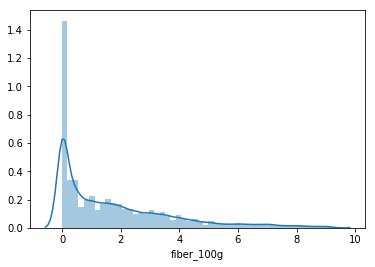

In [68]:
sns.distplot(train['fiber_100g']);

(array([87004., 31841., 22456., 17997., 11148.,  6000.,  4419.,  4328.,
         2595.,  1769.]),
 array([0.   , 0.925, 1.85 , 2.775, 3.7  , 4.625, 5.55 , 6.475, 7.4  ,
        8.325, 9.25 ]),
 <a list of 10 Patch objects>)

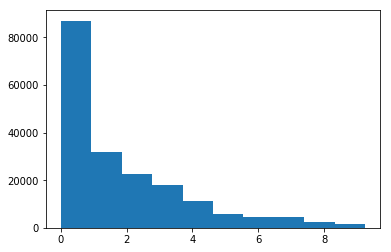

In [69]:
plt.hist(train['fiber_100g'])

### Petit analyse test : fiber 

(array([40440., 14096., 10749.,  7811.,  5193.,  3009.,  1916.,  1936.,
         1195.,   785.]),
 array([-0.09458751,  0.73138153,  1.55735057,  2.3833196 ,  3.20928864,
         4.03525768,  4.86122672,  5.68719575,  6.51316479,  7.33913383,
         8.16510286]),
 <a list of 10 Patch objects>)

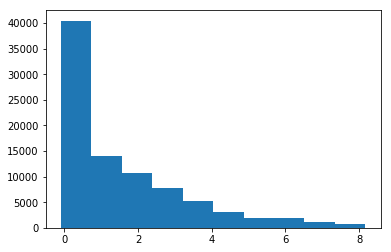

In [70]:
plt.hist(test_clean['fiber_100g'])

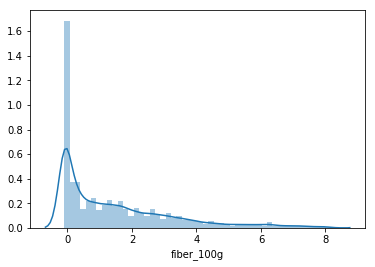

In [71]:
sns.distplot(test_clean['fiber_100g']);

### Analyse des distances

In [72]:
test_clean.head(n=2)

,fiber_100g,proteins_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,carbohydrates_100g,fat_100g,mean_tree,code,product_name,nutrition-score-fr_100g,verif
0,-0.094588,0.209908,1124.952412,0.198196,2.541504,0.047373,5.986183,0.271275,0.177711,4250665323358,Magnesium-Citrat,3.0,6.467366
1,5.920622,12.947544,1593.237537,1.415041,1.187020,1.428436,72.684866,8.096399,0.355403,3268350120688,Biscottes à la farine complète et graines de lin,6.0,93.728808


In [73]:
ind[0]

array([    0, 97415, 60798, 38957, 41838])

In [74]:
dist[0]

array([0.        , 0.17771763, 0.22757305, 0.22990875, 0.25335343])

In [75]:
#Etant donné que cela nous donne l'index de test initial est que nous avons supprimé les doublons ds notre jeu de données
# cleané nous devons utiliser le jeu de données test 
test.iloc[[     0,  32096,  61337,   9811,  18475]]

,code,product_name,generic_name,quantity,fiber_100g,proteins_100g,fruits-vegetables-nuts_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,nutrition-score-fr_100g,carbohydrates_100g,fat_100g,nutriscore_grade
0,4250665323358,Magnesium-Citrat,NaN,℮ 250 g,0.0,0.0,NaN,1139.0,0.0,1.5,0.03,3.0,4.2,0.0,c
32096,8410998003525,Snackium Velarte de Quinoa,NaN,NaN,NaN,11.0,NaN,2038.0,3.8,0.3,1.50,15.0,47.0,27.0,d
61337,24017794,Taco de bacon Delicalo,NaN,300 g,NaN,15.0,NaN,1218.0,8.7,1.3,2.20,20.0,1.5,25.0,e
9811,3266980053062,Pavé de biche mariné à la truffe,Saveurs Forestières Pavé de biche mariné à la ...,"250 g,",0.0,22.0,NaN,464.0,0.0,0.8,1.60,3.0,3.4,1.1,c
18475,2449185029716,Parmigiano reggiano,NaN,NaN,NaN,0.0,NaN,1682.0,20.0,0.0,1.60,22.0,0.0,30.0,e


Ici nous je peux constater une nouvelle anomalie. Pour rappel j'avais retiré les doublons vis à vis du code qui devait être unique(avant de faire mon split train/test).

J'avais ensuite retiré les values qui avaient un mean_tree à 0 si elles avaient exactement les même caractéristiques que sur les colonnes du nutriscore, j'en gardais une seule. Puisque il s'agissait d'un produit identique mais qu'il devait venir d'une autre marque. 

Ici on s'aperçoit que nous avons un problème puisque nous avons deux produits avec le même product_name mais pas la même quantité, cependant les infos st quasis identiques. La ligne 9811 n'a pas été supprimé puisqu'elle possédait Nan donc il a été imputé et a donné un résultat différent pour la comparaison et donc il n'a pas été supprimé. 

Il faudrait s'occuper des doublons sur le product_name en même temps que nous le faisons pour le code

In [76]:
test.loc[(test['fiber_100g'].isna())&(test['proteins_100g'].isna()),:].head(n=2)

,code,product_name,generic_name,quantity,fiber_100g,proteins_100g,fruits-vegetables-nuts_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,nutrition-score-fr_100g,carbohydrates_100g,fat_100g,nutriscore_grade
3,8801005123495,Crispy seaweed snack,NaN,NaN,NaN,NaN,NaN,1799.0,0.0,3.0,2.0,13.0,50.00,0.0,d
113,3421010000441,Jambon Sec,NaN,NaN,NaN,NaN,NaN,929.0,4.4,0.4,NaN,16.0,0.46,7.2,d


Ici on constate que certaines rows possèdent bcp de Nan, donc nous allons vérifier si son nombre peut jouer pour l imputation 

In [77]:
var_nutri=['fiber_100g','proteins_100g',
                'energy_100g','saturated-fat_100g','sugars_100g','salt_100g','carbohydrates_100g','fat_100g']

In [78]:
#Ici je vais pouvoir récuperer le nb de Nan par ligne pour nos colonnes du calcul du nutriscore 
test['Numb_nan_line']=len(var_nutri)-test[var_nutri].apply(lambda x: x.count(),axis=1)

In [79]:
test.head(n=3)

,code,product_name,generic_name,quantity,fiber_100g,proteins_100g,fruits-vegetables-nuts_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,nutrition-score-fr_100g,carbohydrates_100g,fat_100g,nutriscore_grade,Numb_nan_line
0,4250665323358,Magnesium-Citrat,NaN,℮ 250 g,0.0,0.0,NaN,1139.0,0.0,1.5,0.03,3.0,4.2,0.0,c,0
1,3268350120688,Biscottes à la farine complète et graines de lin,Biscottes à la farine complète et graines de lin,270 g,NaN,13.4,NaN,1622.0,1.2,0.3,1.40,6.0,72.0,7.9,c,1
2,4335896750255,Bio Tofu Hack,NaN,200 g,0.5,21.0,NaN,1120.0,2.9,0.8,0.93,4.0,5.2,18.0,c,0


(array([3.1301e+04, 5.0645e+04, 1.6260e+04, 3.0950e+03, 0.0000e+00,
        1.1400e+02, 9.0000e+00, 5.0000e+00, 1.4200e+02, 8.0000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

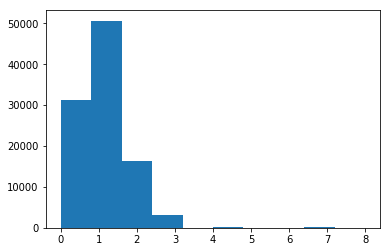

In [80]:
plt.hist(test['Numb_nan_line'])

In [81]:
len(test.loc[test['Numb_nan_line']>4,:])

164

Le nb reste qd même très négligeable 152 row ayant plus de 4 champs à Nan par ligne . 

In [84]:
code=test.loc[(test['Numb_nan_line']>2)&(test['fiber_100g'].isna()),'code']
test.loc[(test['Numb_nan_line']>2)&(test['fiber_100g'].isna()),:]

,code,product_name,generic_name,quantity,fiber_100g,proteins_100g,fruits-vegetables-nuts_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,nutrition-score-fr_100g,carbohydrates_100g,fat_100g,nutriscore_grade,Numb_nan_line
18,3700961303086,Chocolat blond PÂTISSIER,NaN,280 g,NaN,8.1,NaN,2356.0,NaN,NaN,0.560000,29.0,52.00,35.0,e,3
49,3760123182171,Huile de coco,NaN,250 ml,NaN,0.0,NaN,NaN,NaN,0.00,0.000000,20.0,0.00,NaN,e,4
110,8411959000454,Sobrasada de Mallorca,soubressade de Majorque Piquante,150 g,NaN,10.0,NaN,2510.0,NaN,0.50,2.200000,26.0,0.50,NaN,e,3
113,3421010000441,Jambon Sec,NaN,NaN,NaN,NaN,NaN,929.0,4.40,0.40,NaN,16.0,0.46,7.2,d,3
138,3257985460030,Saussisson sec pur porc,NaN,250 g,NaN,NaN,NaN,1874.0,14.40,3.40,NaN,25.0,3.40,35.7,e,3
188,4027109007767,Viva Con Agua - Leise,NaN,700ml,NaN,NaN,NaN,NaN,NaN,NaN,0.004475,0.0,NaN,NaN,a,7
213,3252920015511,Beurre,NaN,250 g,NaN,0.7,NaN,3109.0,NaN,0.60,0.030000,19.0,0.60,NaN,e,3
235,8410076493842,Mélange aux Épices pour Fajitas,Mélange aux Épices pour Fajitas,30 g,NaN,6.3,NaN,1310.0,0.20,NaN,NaN,23.0,67.20,1.3,e,3
268,7350022982314,Ekologiska rostade kokoschips,NaN,200 g,NaN,7.6,NaN,2962.0,NaN,1.80,0.010000,4.0,22.00,NaN,c,3
275,20198183,Bio Kokosnuss öl Nativ,NaN,NaN,NaN,0.0,NaN,3448.0,NaN,0.00,0.000000,20.0,0.00,NaN,e,3


In [85]:
test_clean.loc[test_clean['product_name']=='3256221106411',:]

,fiber_100g,proteins_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,carbohydrates_100g,fat_100g,mean_tree,code,product_name,nutrition-score-fr_100g,verif


In [86]:
test_clean.loc[test_clean['product_name']=='Čerstvé mlieko',:]

,fiber_100g,proteins_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,carbohydrates_100g,fat_100g,mean_tree,code,product_name,nutrition-score-fr_100g,verif
1692,0.129861,3.251732,207.772852,1.110829,6.379208,0.218746,6.625625,1.757058,0.059923,8588004490666,Čerstvé mlieko,0.0,11.634414


In [87]:
test.shape

(101579, 16)

In [88]:
test_clean.shape

(87130, 13)

In [89]:
len(code)

3290

In [90]:
product=test_clean['product_name'].values
len(test.loc[test['product_name'].isin(product),:])

93165

Une explication plausible pourrait-être que je ne recupère pas le code, nutriscore, productname des bon produits lorsque je le rattache à mon df_filled qui st les données imputé. Mais j'ai pourtant vérifié, mais je suis peut être passé à côté de qlq chose. 

# RMSE

- Ici notre problème est que nous avons une différence assez importante des scores Train et Test pour le RMSE : 
    - Train : 3.449
    - Test  : 13.41

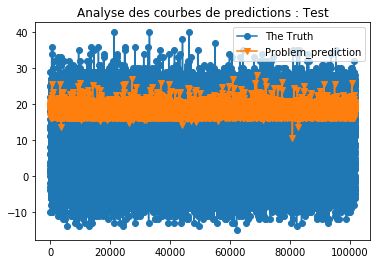

In [91]:
analyse=test_clean.reset_index()
x=analyse['index']
p1=plt.plot(x,y_test1,marker='o')
p2=plt.plot(x,y_pred1,marker='v')
plt.title("Analyse des courbes de predictions : Test")  
plt.legend( ["The Truth", "Problem_prediction"])
plt.show()

In [92]:
taille_totale_test=len(y_test1)
taille_inf_zero=len(y_test1[y_test1<0])
print('Le nb de values inf à 0 ds le nutriscore pour  test :',taille_inf_zero,'soit : ',
                                taille_totale_test/taille_inf_zero,'%')

Le nb de values inf à 0 ds le nutriscore pour  test : 13186 soit :  6.607765812225087 %


In [93]:
taille_totale_test=len(train)
taille_inf_zero=len(train.loc[train['nutrition-score-fr_100g']<0,:])
print('Le nb de values inf à 0 dans le nutriscore pour  train :',taille_inf_zero,'soit : ',
                                taille_totale_test/taille_inf_zero,'%')

Le nb de values inf à 0 dans le nutriscore pour  train : 28394 soit :  6.675952666056209 %
